In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import PredefinedSplit
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats

In [3]:
# === R² OOS function ===
def R2OOS(y_true, y_forecast, expanding_mean):
    y_true = np.array(y_true)
    y_forecast = np.array(y_forecast)
    y_mean = np.array(expanding_mean)

    SSres = sum((y_true - y_forecast)**2)
    SStot = sum((y_true - y_mean)**2)
    return 100*(1 - SSres / SStot)

In [4]:
# ===Clark and West (2007) test for OOS R2 significance ===
def clark_west_test(y_true, y_pred_model, y_pred_benchmark):
    
    error_bench = y_true - y_pred_benchmark
    error_model = y_true - y_pred_model

    # Adjustment term: accounts for model's overfitting tendency
    f_t = error_bench**2 - (error_model**2 - (y_pred_model - y_pred_benchmark)**2)

    # t-test: is the mean of f_t significantly > 0?
    test_stat = np.mean(f_t) / (np.std(f_t, ddof=1) / np.sqrt(len(f_t)))
    p_value = 1 - stats.t.cdf(test_stat, df=len(f_t) - 1)

    return test_stat, p_value


Running Ridge with expanding window...

Forecast 1/348 (1990-01)
Forecast 2/348 (1990-02)
Forecast 3/348 (1990-03)
Forecast 4/348 (1990-04)
Forecast 5/348 (1990-05)
Forecast 6/348 (1990-06)
Forecast 7/348 (1990-07)
Forecast 8/348 (1990-08)
Forecast 9/348 (1990-09)
Forecast 10/348 (1990-10)
Forecast 11/348 (1990-11)
Forecast 12/348 (1990-12)
Forecast 13/348 (1991-01)
Forecast 14/348 (1991-02)
Forecast 15/348 (1991-03)
Forecast 16/348 (1991-04)
Forecast 17/348 (1991-05)
Forecast 18/348 (1991-06)
Forecast 19/348 (1991-07)
Forecast 20/348 (1991-08)
Forecast 21/348 (1991-09)
Forecast 22/348 (1991-10)
Forecast 23/348 (1991-11)
Forecast 24/348 (1991-12)
Forecast 25/348 (1992-01)
Forecast 26/348 (1992-02)
Forecast 27/348 (1992-03)
Forecast 28/348 (1992-04)
Forecast 29/348 (1992-05)
Forecast 30/348 (1992-06)
Forecast 31/348 (1992-07)
Forecast 32/348 (1992-08)
Forecast 33/348 (1992-09)
Forecast 34/348 (1992-10)
Forecast 35/348 (1992-11)
Forecast 36/348 (1992-12)
Forecast 37/348 (1993-01)
Forecas

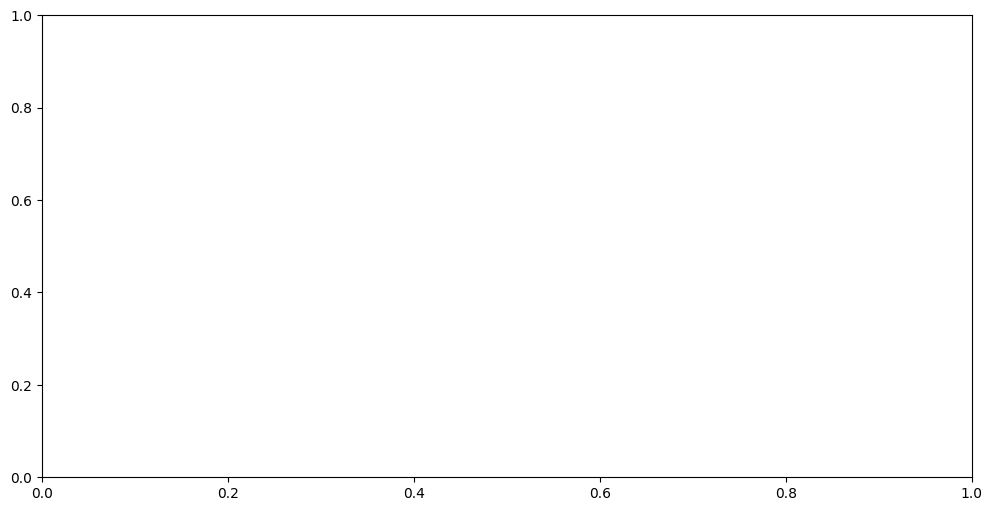

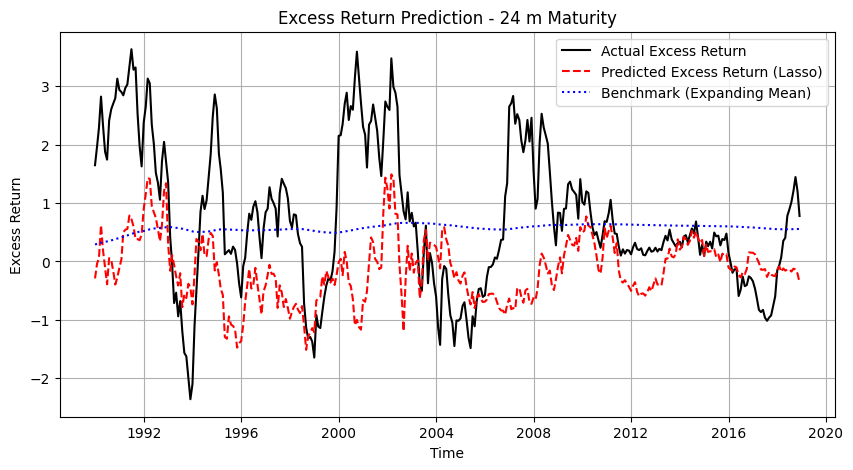

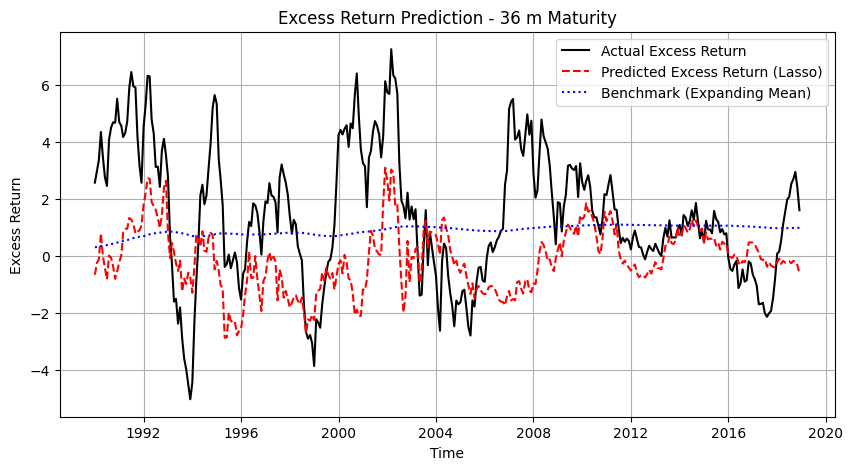

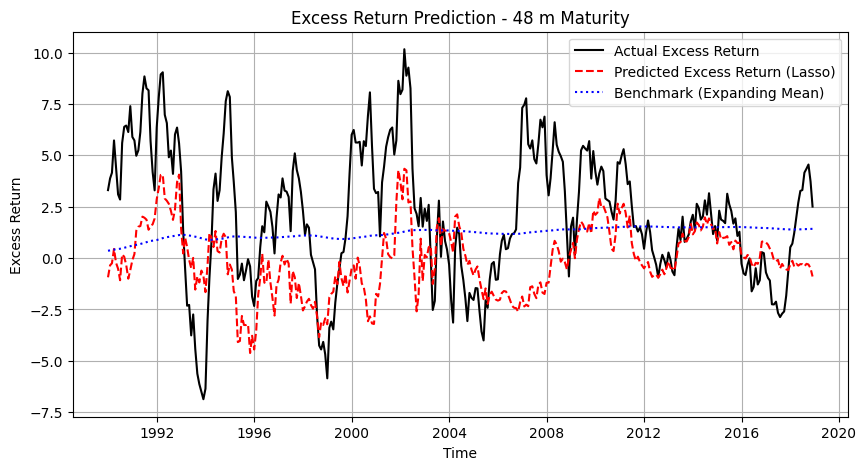

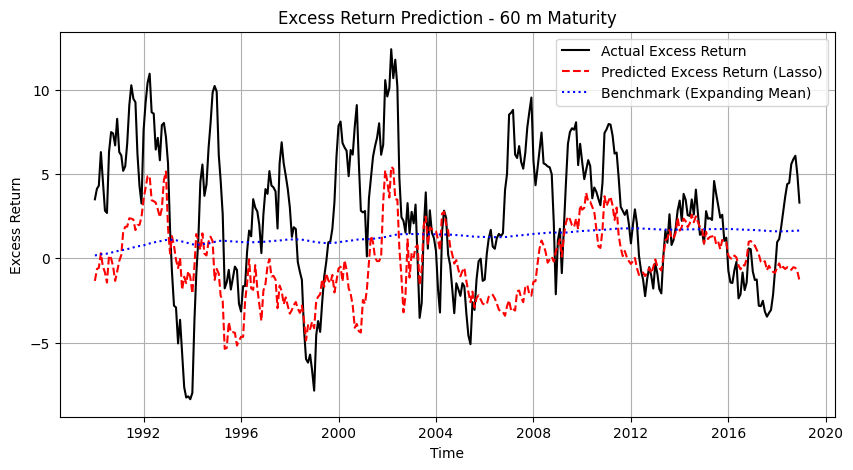

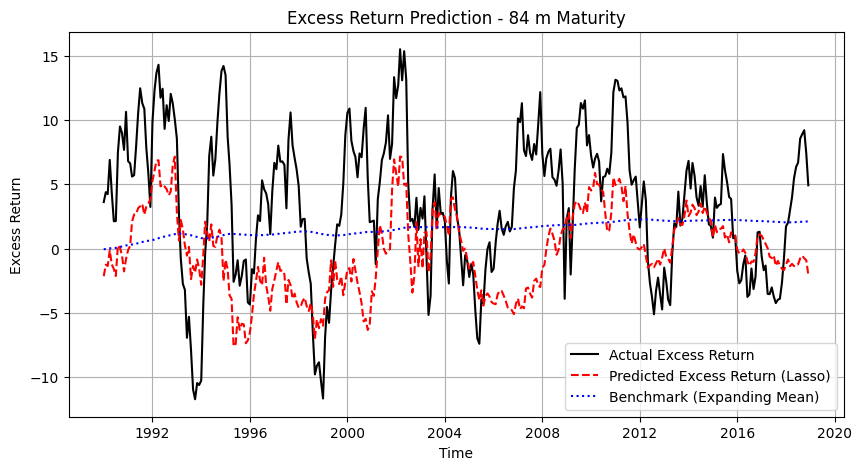

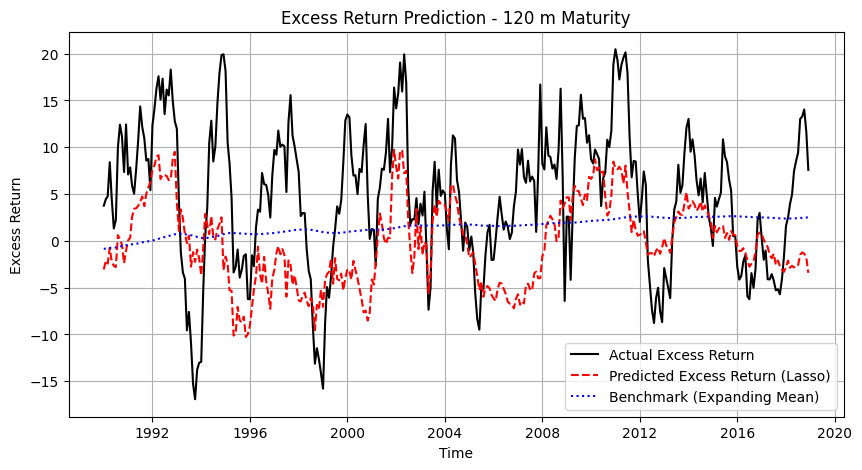

In [27]:
# === SETTINGS ===
EXCESS_RETURN_PATH = '/Users/Siebe.van.Wingerden/Desktop/Python Codes/xr2.xlsx'
FWD_RATE_PATH = '/Users/Siebe.van.Wingerden/Desktop/Python Codes/fwd2.xlsx'
OOS_START_DATE = "1990-01-01"
OOS_END_DATE = "2018-12-01"
FULL_START_DATE = "1971-08-01"  # for full sample filtering

# === Load and align data ===
df_xr = pd.read_excel(EXCESS_RETURN_PATH)
df_fwd = pd.read_excel(FWD_RATE_PATH)

# Normalize column names
df_xr.columns = [c.strip().lower() for c in df_xr.columns]
df_fwd.columns = [c.strip().lower() for c in df_fwd.columns]

df_xr['date'] = pd.to_datetime(df_xr['date'])
df_fwd['date'] = pd.to_datetime(df_fwd['date'])

df = pd.merge(df_xr, df_fwd, on="date", suffixes=("_xr", "_fwd"))
df.set_index("date", inplace=True)

regressor_maturities = ["12 m", "24 m", "36 m", "48 m", "60 m", "72 m", "84 m", "96 m", "108 m", "120 m"]
fwd_cols = [m + "_fwd" for m in regressor_maturities]

target_maturities = ["24 m", "36 m", "48 m", "60 m", "84 m", "120 m"]
target_cols = [m + "_xr" for m in target_maturities]

# Limit full data to training + OOS period
df = df[(df.index >= FULL_START_DATE) & (df.index <= OOS_END_DATE)].copy()

# === Prepare arrays ===
Y = df[target_cols].to_numpy()
Xexog = df[fwd_cols].to_numpy()
dates = df.index.to_numpy()

# === Run Expanding Window Forecast from 1990-01 ===
n_obs = Y.shape[0]
n_maturities = Y.shape[1]

expanding_mean_check = np.full_like(Y, np.nan, dtype=np.float64)
for t in range(0,n_obs):
    expanding_mean_check[t, :] = Y[:t+1, :].mean(axis=0)

expanding_mean_df = pd.DataFrame(expanding_mean_check, columns=target_maturities, index=df.index)
expanding_mean_df = expanding_mean_df.iloc[221:]
#print(expanding_mean_df.head())

# Determine first forecast index corresponding to 1990-01-01
start_oos_idx = df.index.get_loc(pd.to_datetime(OOS_START_DATE))

y_preds = np.full_like(Y, np.nan)

def run_ridge(X_train, Y_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test.reshape(1, -1))
    N_train = int(np.round(np.size(X_train_scaled,axis=0)*0.85))
    N_val = np.size(X_train_scaled,axis=0)-N_train
    test_fold =  np.concatenate(((np.full((N_train),-1),np.full((N_val),0))))
    ps = PredefinedSplit(test_fold.tolist())
    model = RidgeCV(cv=ps)
    Y_pred = np.full((1, Y_train.shape[1]), np.nan)  

    for i in range(Y_train.shape[1]):  
        model.fit(X_train_scaled, Y_train[:, i])
        Y_pred[0, i] = model.predict(X_test_scaled)[0]  

    return Y_pred

y_preds = np.full_like(Y, np.nan)
print("Running Ridge with expanding window...\n")

# Expanding window loop
for t in range(start_oos_idx, len(Y)):
    y_preds[t, :] = run_ridge(Xexog[:t+1, :], Y[:t+1, :], Xexog[t, :])
    print(f"Forecast {t+1 - start_oos_idx}/{len(Y) - start_oos_idx} ({df.index[t].strftime('%Y-%m')})")

# === Performance Evaluation #1===
print("\n=== Ridge Regression OOS Performance ===")
for i, col in enumerate(target_maturities):
    y_true = Y[start_oos_idx:, i]
    y_forecast = y_preds[start_oos_idx:, i]
    benchmark = expanding_mean_df[col].iloc[0:len(y_true)].values
    r2 = R2OOS(y_true, y_forecast, benchmark)
    rmse = np.sqrt(mean_squared_error(y_true, y_forecast))
    mae = mean_absolute_error(y_true, y_forecast)
    cw_stat, cw_p = clark_west_test(y_true, y_forecast, benchmark)

    print(f"{col}: R²OOS={r2:.4f}%, RMSE={rmse:.4f}, MAE={mae:.4f}, Clark and West stat={cw_stat:.2f}, p-value={cw_p:.4f}")

# === Plot Results ===
fig, ax = plt.subplots(figsize=(12, 6))

for i, col in enumerate(target_maturities):
    plt.figure(figsize=(10, 5))  # Create a new figure for each maturity
    
    y_true = Y[start_oos_idx:, i]
    y_forecast = y_preds[start_oos_idx:, i]
    expanding_mean_for_maturity = expanding_mean_df[col].iloc[0:len(y_true)].values

    plt.plot(df.index[start_oos_idx:], y_true, label="Actual Excess Return", color="black", linestyle="-")
    plt.plot(df.index[start_oos_idx:], y_forecast, label="Predicted Excess Return (Lasso)", color="red", linestyle="--")
    plt.plot(df.index[start_oos_idx:], expanding_mean_for_maturity, label="Benchmark (Expanding Mean)", color="blue", linestyle=":")
    plt.xlabel("Time")
    plt.ylabel("Excess Return")
    plt.title(f"Excess Return Prediction - {col} Maturity")
    plt.legend()
    plt.grid(True)
    plt.show()

    #Model xyz was no model on this that that so we used our own hyperparameter gridsearch so might be unoptimal and points ot the incompleteness of the paper. To the best of our abilities we tried to replicate the results.